In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import load_model
from datetime import datetime


In [3]:
import os
print(os.getcwd())


c:\Users\dprih\OneDrive\Dokumen\ITS\ITS Semester 6\Capstone-Bangkit-ML\forecasting\model


In [24]:
# Memuat data
data = pd.read_csv("C:\\Users\\dprih\\OneDrive\\Dokumen\\ITS\\ITS Semester 6\\Capstone-Bangkit-ML\\scrap-data-new\\new-scrap-mean\\bawang_merah_mean.csv")
data['tanggal'] = pd.to_datetime(data['tanggal'])
data.set_index('tanggal', inplace=True)
data

,no,hrg
tanggal,,
2023-01-01,0,31497.447368
2023-01-02,1,31321.578947
2023-01-03,2,31469.868421
2023-01-04,3,31473.815789
2023-01-05,4,31519.789474
...,...,...
2024-06-11,529,36350.052632
2024-06-12,530,36373.315789
2024-06-13,531,36038.473684


In [25]:
#Drop the no 
data = data.drop(columns=['no'])
data

,hrg
tanggal,
2023-01-01,31497.447368
2023-01-02,31321.578947
2023-01-03,31469.868421
2023-01-04,31473.815789
2023-01-05,31519.789474
...,...
2024-06-11,36350.052632
2024-06-12,36373.315789
2024-06-13,36038.473684


In [26]:
# Menormalisasi data harga
scaler = MinMaxScaler(feature_range=(0, 1))
data['hrg'] = scaler.fit_transform(data['hrg'].values.reshape(-1,1))

In [27]:
# Membuat dataset untuk LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [28]:
# Parameter
time_step = 10

In [29]:
# Membagi data menjadi train dan test
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:len(data)]

In [30]:
# Membuat dataset untuk train dan test
trainX, trainY = create_dataset(train.values, time_step)
testX, testY = create_dataset(test.values, time_step)

In [31]:
# Mengubah input menjadi [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

In [32]:
# Membangun model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Menampilkan ringkasan model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9), loss=tf.keras.losses.Huber())

# Melatih model
model.fit(trainX, trainY, batch_size=1, epochs=20)

Epoch 1/20
415/415 [==============================] - 4s 5ms/step - loss: 0.0046
Epoch 2/20
415/415 [==============================] - 2s 6ms/step - loss: 0.0013
Epoch 3/20
415/415 [==============================] - 3s 6ms/step - loss: 0.0013
Epoch 4/20
415/415 [==============================] - 3s 6ms/step - loss: 0.0011
Epoch 5/20
415/415 [==============================] - 2s 6ms/step - loss: 0.0013
Epoch 6/20
415/415 [==============================] - 2s 6ms/step - loss: 0.0012
Epoch 7/20
415/415 [==============================] - 2s 6ms/step - loss: 0.0012
Epoch 8/20
415/415 [==============================] - 3s 6ms/step - loss: 0.0011
Epoch 9/20
415/415 [==============================] - 3s 6ms/step - loss: 0.0010
Epoch 10/20
415/415 [==============================] - 2s 6ms/step - loss: 0.0011
Epoch 11/20
415/415 [==============================] - 3s 6ms/step - loss: 0.0011
Epoch 12/20
415/415 [==============================] - 3s 6ms/step - loss: 9.2278e-04
Epoch 13/20
415/415 [

In [34]:
# Melakukan prediksi
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

3/3 [==============================] - 0s 3ms/step


In [35]:
# Mengembalikan harga ke skala semula
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

In [36]:
# Menghitung MAPE untuk train dan test
mape_train = mean_absolute_percentage_error(trainY, train_predict) * 100
mape_test = mean_absolute_percentage_error(testY, test_predict) * 100

print(f"MAPE Train: {mape_train}%")
print(f"MAPE Test: {mape_test}%")

MAPE Train: 3.5898535414677504%
MAPE Test: 5.571353527388032%


In [37]:

# Membuat dataframe untuk hasil prediksi train
train_predict_df = pd.DataFrame({
    'tanggal': data.index[time_step:len(train_predict) + time_step],
    'harga_asli': trainY.flatten(),
    'harga_prediksi': train_predict.flatten()
})
train_predict_df.set_index('tanggal', inplace=True)

# Membuat dataframe untuk hasil prediksi test
test_predict_df = pd.DataFrame({
    'tanggal': data.index[len(train_predict) + (time_step * 2) + 1:len(data) - 1],
    'harga_asli': testY.flatten(),
    'harga_prediksi': test_predict.flatten()
})
test_predict_df.set_index('tanggal', inplace=True)

# Menampilkan hasil prediksi train
print("Hasil Prediksi Train:")
print(train_predict_df.head())

# Menampilkan hasil prediksi test
print("Hasil Prediksi Test:")
print(test_predict_df.head())

Hasil Prediksi Train:
              harga_asli  harga_prediksi
tanggal                                 
2023-01-11  32164.342105    30891.333984
2023-01-12  32258.552632    30984.638672
2023-01-13  32313.868421    31073.681641
2023-01-14  32218.710526    31155.193359
2023-01-15  32216.052632    31212.138672
Hasil Prediksi Test:
              harga_asli  harga_prediksi
tanggal                                 
2024-03-12  27504.157895    26439.738281
2024-03-13  27531.789474    26502.466797
2024-03-14  27516.078947    26560.332031
2024-03-15  27684.736842    26609.855469
2024-03-16  27695.052632    26666.560547


In [38]:
# Prediksi harga masa depan
future_steps = 30  # jumlah langkah ke depan yang ingin diprediksi
last_sequence = data.values[-time_step:]  # ambil urutan terakhir dari data

future_predictions = []

for _ in range(future_steps):
    # Ubah bentuk input menjadi [samples, time steps, features]
    input_sequence = last_sequence.reshape((1, time_step, 1))
    next_prediction = model.predict(input_sequence)
    future_predictions.append(next_prediction[0, 0])
    
    # Perbarui urutan terakhir dengan menggeser ke kiri dan menambahkan prediksi terbaru
    last_sequence = np.append(last_sequence[1:], next_prediction)[-time_step:]

# Mengembalikan harga ke skala semula untuk prediksi masa depan
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Membuat tanggal untuk prediksi masa depan
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, inclusive='right')

# Membuat dataframe untuk hasil prediksi masa depan
future_predict_df = pd.DataFrame({
    'tanggal': future_dates,
    'harga_prediksi': future_predictions.flatten()
})
future_predict_df.set_index('tanggal', inplace=True)

# Menampilkan hasil prediksi masa depan
print("Hasil Prediksi Masa Depan:")
print(future_predict_df.head())

1/1 [==============================] - 0s 16ms/step
Hasil Prediksi Masa Depan:
            harga_prediksi
tanggal                   
2024-06-16    34349.367188
2024-06-17    33621.464844
2024-06-18    33126.195312
2024-06-19    32750.746094
2024-06-20    32438.421875


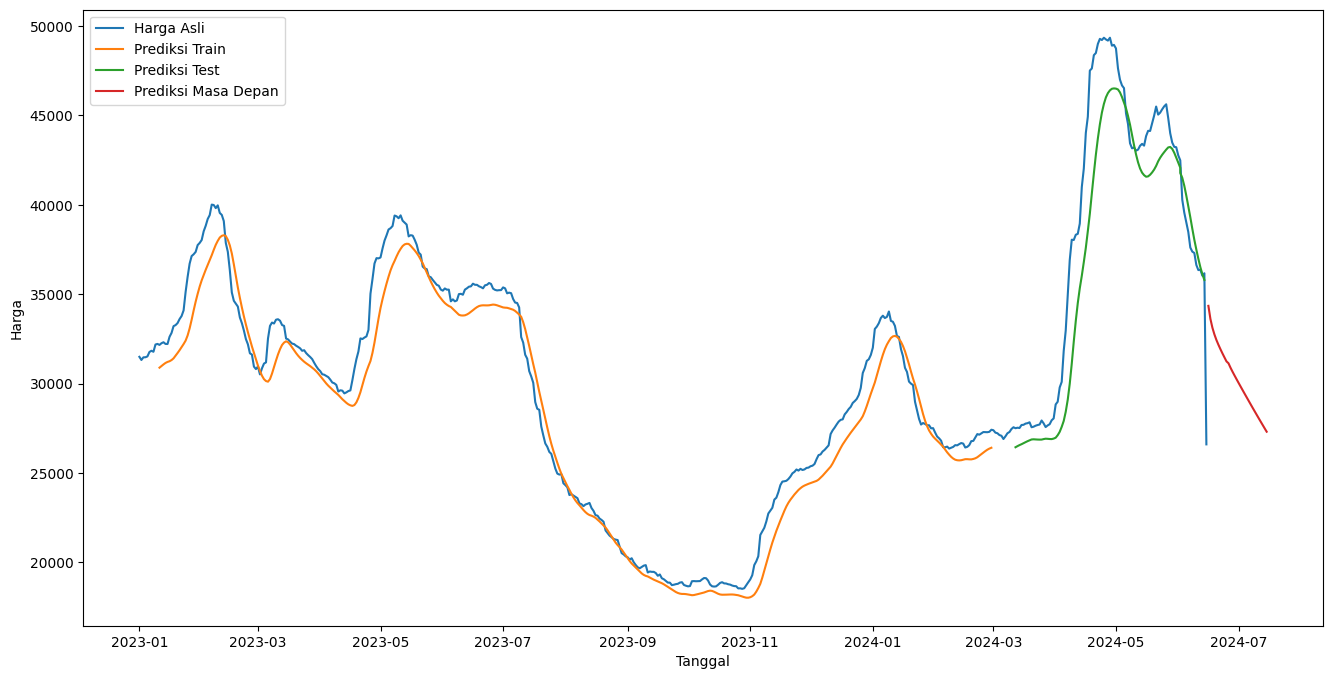

In [39]:
# Visualisasi hasil
plt.figure(figsize=(16,8))
plt.plot(data.index, scaler.inverse_transform(data['hrg'].values.reshape(-1, 1)), label='Harga Asli')
plt.plot(data.index[time_step:len(train_predict) + time_step], train_predict, label='Prediksi Train')
plt.plot(data.index[len(train_predict) + (time_step * 2) + 1:len(data) - 1], test_predict, label='Prediksi Test')
plt.plot(future_predict_df.index, future_predict_df['harga_prediksi'], label='Prediksi Masa Depan')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.show()

## Saving the Model in Different Formats:
- Pickle

In [ ]:
import pickle

# Save the model using Pickle
with open('bawang_merah_forecasting.pkl', 'wb') as file:
    pickle.dump(model, file)

# Load the model using Pickle
with open('bawang_merah_forecasting.pkl', 'rb') as file:
    loaded_model_pickle = pickle.load(file)

- H5

In [40]:
# Save the model using H5 format
model.save('bawang_merah_forecasting.h5')

# Load the model using H5 format
from tensorflow.keras.models import load_model
loaded_model_h5 = load_model('bawang_merah_forecasting.h5')

- Tensorflow Saved Model

In [ ]:
# Save the model using TensorFlow SavedModel format
model.save('saved_model/bawang_merah_forecasting')

# Load the model using TensorFlow SavedModel format
loaded_model_saved = tf.keras.models.load_model('saved_model/bawang_merah_forecasting')

- TensorFlow Lite

In [ ]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('bawang_merah_forecasting.tflite', 'wb') as file:
    file.write(tflite_model)

# Load the TensorFlow Lite model (for inference, not training)
interpreter = tf.lite.Interpreter(model_path='bawang_merah_forecasting.tflite')
interpreter.allocate_tensors()

# Getting input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

## Testing Model with another input

In [53]:
# Memuat data
data = pd.read_csv("C:\\Users\\dprih\\OneDrive\\Dokumen\\ITS\\ITS Semester 6\\Capstone-Bangkit-ML\\scrap-data-new\\new-scrap-mean\\bawang_merah_mean.csv")
data['tanggal'] = pd.to_datetime(data['tanggal'])
data.set_index('tanggal', inplace=True)
data = data.drop(columns=['no'])

In [54]:
# Load the model
model = load_model('bawang_merah_forecasting.h5')

In [55]:
date_input = input("Masukkan tanggal (YYYY-MM-DD): ")


In [56]:
start_date = datetime.strptime('2023-01-01', '%Y-%m-%d')
date_input = datetime.strptime(date_input, '%Y-%m-%d')
date_input = (date_input - start_date).days

In [57]:
# Assuming date_input is a single timestep and you want to use dummy data for the other 9 timesteps
date_input = np.array([date_input] * 10)

# Reshape your data to match the input shape that your model expects
date_input = np.reshape(date_input, (1, 10, 1))

In [58]:

prediction = model.predict(date_input)

# Load the original data
original_data = data

# Create a new MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler with the original data
scaler.fit(original_data)

# Now you can use the scaler to reverse the scaling
prediction = scaler.inverse_transform(prediction)

print(prediction)

1/1 [==============================] - 0s 496ms/step
[[75449.445]]


## Testing model with another input V2

In [69]:
# Memuat data
data = pd.read_csv("C:\\Users\\dprih\\OneDrive\\Dokumen\\ITS\\ITS Semester 6\\Capstone-Bangkit-ML\\scrap-data-new\\new-scrap-mean\\bawang_merah_mean.csv")
data['tanggal'] = pd.to_datetime(data['tanggal'])
data.set_index('tanggal', inplace=True)
data = data.drop(columns=['no'])
data

,hrg
tanggal,
2023-01-01,31497.447368
2023-01-02,31321.578947
2023-01-03,31469.868421
2023-01-04,31473.815789
2023-01-05,31519.789474
...,...
2024-06-11,36350.052632
2024-06-12,36373.315789
2024-06-13,36038.473684


In [70]:
model = load_model('bawang_merah_forecasting.h5')
time_step=10

In [71]:
# Create a new MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler with the original data
# scaler.fit(data)
data['hrg'] = scaler.fit_transform(data['hrg'].values.reshape(-1,1))

In [73]:
# Assumptions (since they were not provided in the original code)
# model, data, time_step, and scaler should be already defined in your environment

# Ask the user for the future date
future_date_str = input("Enter the future date to predict (YYYY-MM-DD): ")
future_date = pd.to_datetime(future_date_str)

# Calculate the number of future steps
last_date = data.index[-1]
future_steps = (future_date - last_date).days

if future_steps <= 0:
    raise ValueError("The future date must be later than the last date in the dataset.")

# Extract the last sequence from the data
last_sequence = data.values[-time_step:]  # Assumes `data` is a pandas DataFrame

# Generate predictions for the specified future steps
for _ in range(future_steps):
    # Reshape the input to [samples, time steps, features]
    input_sequence = last_sequence.reshape((1, time_step, 1))
    next_prediction = model.predict(input_sequence)
    
    # Update the last sequence by shifting left and adding the latest prediction
    last_sequence = np.append(last_sequence[1:], next_prediction)[-time_step:]

# Rescale the final prediction back to the original scale
final_prediction = scaler.inverse_transform(np.array(next_prediction).reshape(-1, 1))

# Display the final prediction
print(f"Predicted price for {future_date_str}: {final_prediction[0, 0]}")


1/1 [==============================] - 0s 16ms/step
Predicted price for 2024-06-24: 31464.244140625


: 